In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
from typing import Tuple
import cv2
import math
import scipy

In [2]:
# Borrowed sliding window masking from repo:
# https://github.com/XAITK/xaitk-saliency/blob/master/xaitk_saliency/impls/perturb_image/sliding_window.py
class SlidingWindow ():
    """
    Produce perturbation  matrices based on hard, block-y occlusion areas as
    generated by sliding a window of a configured size over the area of an
    image.
    Due to the geometry of sliding windows, if the stride given does not evenly
    divide the window size along the applicable axis, then the result plane of
    values when summing the generated masks will not be even.
    Related, if the stride is set to be larger than the window size, the
    resulting plane of summed values will also not be even, as there be
    increasingly long valleys of unperturbed space between masked regions.
    :param window_size: The block window size in pixels as a tuple with format
        `(height, width)`.
    :param stride: The sliding window striding step in pixels as a tuple with
        format `(height_step, width_step)`.
    """

    def __init__(
        self,
        window_size: Tuple[int, int] = (25, 25),
        stride: Tuple[int, int] = (5, 5),
    ):
        self.window_size: Tuple[int, int] = (int(window_size[0]), int(window_size[1]))
        self.stride: Tuple[int, int] = (int(stride[0]), int(stride[1]))

    def perturb(
        self,
        ref_image: np.ndarray
    ) -> np.ndarray:
        win_h, win_w = self.window_size
        stride_h, stride_w = self.stride
        img_size = ref_image.shape[:2]
        img_h, img_w = img_size
        rows = np.arange(0 + stride_h - win_h, img_h, stride_h)
        cols = np.arange(0 + stride_w - win_w, img_w, stride_w)

        num_masks = len(rows) * len(cols)
        masks = np.zeros((num_masks, img_h, img_w), dtype=int)
        rows_m = np.repeat(rows, len(cols))
        cols_m = np.tile(cols, len(rows))

        for i, (r, c) in enumerate(zip(rows_m, cols_m)):
            # use of np.clip function here is more costly than min/max use.
            r1 = max(0, r)
            r2 = min(r + win_h, img_h)
            c1 = max(0, c)
            c2 = min(c + win_w, img_w)
            rs = slice(r1, r2)
            cs = slice(c1, c2)
            masks[i, rs, cs] = 1
        return masks

[[  1.21317506   1.21317506   1.21264982 ... 105.32375336  46.25015259
   17.25676155]
 [  1.54341471   1.52561092   1.18746495 ... 114.72424316 114.80496216
   72.25167084]
 [  1.21317506   1.21317506   1.20681715 ... 120.70223999 117.48383331
   35.64147186]
 ...
 [  1.20717788   0.94707382   1.22145057 ... 130.49687195 109.729599
   63.05652618]
 [  1.21317506   1.51988375   1.21317506 ... 132.81600952 126.11454773
  111.92025757]
 [  1.21319675   1.21602976   1.21317506 ... 125.41462708 103.67741394
   14.76316643]]


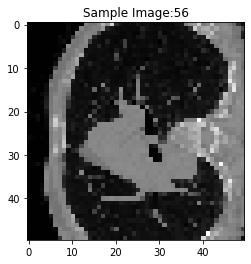

In [3]:
image_size=50
# Defining the image ground truth for which we need to simulate observations
gt_filepath = "./ground_truth_test_000.hdf5"
sample_ids = random.sample(range(0, 127), 1)
# Loading ground truth file for the observation data loaded above
with h5py.File(gt_filepath, "r") as gtf:
    for i, ids in enumerate(sample_ids):
        sample_x = gtf['data'][ids, :, :]
        sample_x = cv2.resize(sample_x, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        sample_x = (255 * (sample_x - np.min(sample_x)) / np.ptp(sample_x)).astype(float)

# Visualize the image
print(sample_x)
plt.figure()
plt.imshow(sample_x, cmap='gray')
plt.title('Sample Image:{}'.format(sample_ids[0]))
plt.show()
plt.close()

# Obtain actual vector x used in model
x_flatten = sample_x.flatten()

In [4]:
# Simulating observations along diagonals
x, y = sample_x.shape
string_list = []
for i in range(x):
	for j in range(y):
		string_list.append("{},{}".format(i, j))
indices_A = np.array(string_list, dtype = 'object').reshape(x, y)

# Computing rays along all possible diagonals and their respective indices ('row', 'column')
def sample_diag(sample_x):
	diags = [sample_x[::-1, :].diagonal(i) for i in range(-sample_x.shape[0]+1, sample_x.shape[1])]
	diags.extend(sample_x.diagonal(i) for i in range(sample_x.shape[1]-1, -sample_x.shape[0], -1))
	return [n.tolist() for n in diags]
diag_indic = sample_diag(indices_A)

In [5]:
# Simulating observations along all columns
column_arr = []
column_indic_global = []
for j in range(y):
	columns = [row[j] for row in sample_x]
	column_arr.append(columns)
	column_indic = []
	for r_cnt in range(x):
		column_indic.append("{},{}".format(r_cnt, j))
	column_indic_global.append(column_indic)

In [6]:
# Simulating observations along all rows
rows_arr = []
row_indic_global = []
for j in range(x):
	rows = [row for row in sample_x[j, :]]
	rows_arr.append(rows)
	row_indic = []
	for c_cnt in range(y):
		row_indic.append("{},{}".format(j, c_cnt))
	row_indic_global.append(row_indic)

In [7]:
# Using a sliding window of size 25 and stride 5 for observations
window_arr = []
window_indic_global = []

for i in [3, 5]:
    # Iterate through multiple window size and stride for more observations
    sd = SlidingWindow((i, i), (2, 1))
    masks = sd.perturb(sample_x)
    for m_n, mask in enumerate(masks):
        window_arr = []
        N = sum(mask)
        A_ind = np.where(mask == 1)
        window_arr = ["{},{}".format(A_row, A_col) for A_row, A_col in zip(A_ind[0], A_ind[1])]
        window_indic_global.append(window_arr)

In [9]:
midp = image_size//2

def intermediates(p1, p2, nb_points=8):
    x_spacing = (p2[0] - p1[0]) / (nb_points + 1)
    y_spacing = (p2[1] - p1[1]) / (nb_points + 1)

    return [[p1[0] + i * x_spacing, p1[1] +  i * y_spacing] 
            for i in range(1, nb_points+1)]

def plot_point(point, angle, length, cnt):
    x, y = point
    endy = y + length * math.sin(math.radians(angle))
    endx = length * math.cos(math.radians(angle))
    # plot the points
    int_p = np.array(intermediates([x, y], [endx, endy], nb_points=image_size))
# Uncomment for saving image
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     ax.set_ylim([0, image_size]) 
#     ax.set_xlim([0, image_size])
#     ax.set_title(str(angle))
#     ax.plot([x, endx], [y, endy])
#     ax.plot(int_p[:, 0], int_p[:, 1], 'or');
#     ax.imshow(sample_x, cmap='gray')
#     fig.show()
#     fig.savefig('./test_folder/{}_plot.png'.format(cnt))
    return int_p
angle_dis_global = []
k = 0
left_origin = []
left_angles = []
for i in range(1, image_size-1, 5):
    left_origin.append([0, i])
    left_angles.append([-8900, 8900])

top_origin = []
top_angles = []
for i in range(1, image_size-1, 7):
    top_origin.append([i, image_size])
    top_angles.append([5000, 38000])

all_origins = [*left_origin, *top_origin]
all_angles = [*left_angles, *top_angles]
step = 18

for i, (start_p, start_ang) in enumerate(zip(all_origins, all_angles)):
    for ang in range(start_ang[0], start_ang[1], step):
        filtered_points = []
        k += 1
        intermediate_points_o = np.round(plot_point(start_p, ang*0.01, int(1.4*image_size), k))
        for int_points in intermediate_points_o:
            if int_points[0]<= image_size - 1 and int_points[1] <= image_size - 1 and int_points[0]>0 and int_points[1]>0:
                filtered_points.append("{},{}".format(int(int_points[0]), int(int_points[1])))
        angle_dis_global.append(filtered_points)

In [10]:
from scipy.sparse import csr_matrix

# Joining all simulation lists
# Uncomment for using sliding window
# all_indices = [*diag_indic, *column_indic_global, *row_indic_global, *window_indic_global, *angle_dis_global]
all_indices = [*diag_indic, *column_indic_global, *row_indic_global, *angle_dis_global]
# Removing empty observations
all_indices = [element for element in all_indices if element]

# Creating empty mixing matrix A for model
row_dim, col_dim = np.shape(sample_x)
A_mixing_matrix = np.zeros((len(all_indices), row_dim, col_dim))
for obs_n, ind in enumerate(all_indices):
	for sub_i in ind:
		local_x, local_y = sub_i.split(',')
		A_mixing_matrix[obs_n, int(local_x), int(local_y)] = 1
A_final = A_mixing_matrix.reshape((obs_n+1, row_dim*col_dim))
A_final_sp = csr_matrix(A_final)
# Pure observations are used for lambda to sample from poisson distribution
pure_obser = A_final_sp@x_flatten
poisson_obser = np.random.poisson(pure_obser, len(all_indices))

In [11]:
# Saving to mat files for use in MATLAB
# np.save('simulated_large_A_{}_{}.npy'.format(sample_ids[0], image_size), A_final)
scipy.sparse.save_npz('simulated_large_A_{}_{}.npz'.format(sample_ids[0], image_size), A_final_sp)
np.save('simulated_large_x_{}_{}.npy'.format(sample_ids[0], image_size), x_flatten)

print("Image vector x is of shape {}".format(len(x_flatten)))
print("Mixing matrix A is of shape {}".format(np.shape(A_final_sp)))
print("Obervation matrix Y is of shape {}".format(np.shape(poisson_obser)))
print("X:", x_flatten)
print("A:", A_final)
print("Y:", poisson_obser)
print("Y without poisson", pure_obser)

Image vector x is of shape 2500
Mixing matrix A is of shape (16194, 2500)
Obervation matrix Y is of shape (16194,)
X: [  1.21317506   1.21317506   1.21264982 ... 125.41462708 103.67741394
  14.76316643]
A: [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Y: [  2   2   3 ... 151  16  12]
Y without poisson [  1.21317506   2.75658977   3.9514358  ... 126.683424    14.76316643
  14.76316643]


# Uncomment for creating gif
import imageio
import glob
import os
import re
images = []
im_names = []
fold_path = "./test_folder"
main_path = "./test_folder/*.png"
for filename in glob.glob(main_path):
    im_names.append(filename.split('/')[-1])
im_names.sort(key=lambda f: int(re.sub('\D', '', f)))
# im_names.sort(key=lambda f: int(filter(str.isdigit, f)))
for filename in im_names:
    images.append(imageio.imread(os.path.join(fold_path, filename)))
imageio.mimsave('scan.gif', images)